In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Plotting.plotters as plotters


/home/kian/anaconda3/envs/thesis/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


In [3]:
import numpy as np

# Number of samples
q1_low  = -torch.pi/2
q1_high = torch.pi/2
q2_low  = -torch.pi/2
q2_high = torch.pi/2
q1_d_low  = -torch.pi/2
q1_d_high = torch.pi/2
q2_d_low  = -torch.pi/2
q2_d_high = torch.pi/2


n_samples = 100000

# Generate uniformly distributed points for q1 and q2
q1 = torch.linspace(q1_low, q1_high, n_samples)
q2 = torch.linspace(q2_low, q2_high, n_samples)
q1_d = torch.linspace(q1_d_low, q1_d_high, n_samples)
q2_d = torch.linspace(q2_d_low, q2_d_high, n_samples)

idx = torch.randperm(q2.shape[0])
idx2 = torch.randperm(q1_d.shape[0])
idx3 = torch.randperm(q2_d.shape[0])

q2 = q2[idx]
q1_d = q1_d[idx2]
q2_d = q2_d[idx3]

# Stack q1 and q2 to get the 2D coordinates
points = torch.stack([q1, q2, q1_d, q2_d], axis=1)#.to(device)  # Shape will be (1000, 2)

In [4]:
# Use TensorDataset to create the dataset
dataset = TensorDataset(points)

# Create the DataLoader with batch size and shuffling
batch_size = 512
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in dataloader:
    #print(batch[0])
    break  # Just to show one batch

In [5]:
class SinCosLayer(nn.Module):
    def __init__(self):
        super(SinCosLayer, self).__init__()

    def forward(self, x):
        # Apply sin() and cos() to both coordinates
        x_sin = torch.sin(x)
        x_cos = torch.cos(x)
        x_sin_cos_shape = (x.shape[0], x.shape[1]*2)
        x_sin_cos = torch.empty(x_sin_cos_shape, dtype=x_sin.dtype, device=x.device)
        x_sin_cos[:,0::2] = x_sin
        x_sin_cos[:,1::2] = x_cos
        return x_sin_cos
    
# Custom layer to reverse the interleaved sin() and cos() back to original coordinates
class InverseSinCosLayer(nn.Module):
    def __init__(self):
        super(InverseSinCosLayer, self).__init__()

    def forward(self, x):
        # x contains interleaved sin() and cos() values
        # Assuming input is of shape (batch_size, 4) for 2D coordinates
        sin_vals = x[:, 0::2]  # Extract sin values
        cos_vals = x[:, 1::2]  # Extract cos values

        # Use atan2 to recover the original angles from sin and cos
        original_coords = torch.atan2(sin_vals, cos_vals)
        return original_coords
    



class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            #SinCosLayer(),
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            #nn.Linear(8, 8),
            #nn.Sigmoid(),
            #nn.Linear(8, 4),
            #nn.Sigmoid(),
            nn.Linear(4, 1)#,
            #InverseSinCosLayer()
        )
        
        
        self.decoder = nn.Sequential(
            #SinCosLayer(),
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            #nn.Linear(8, 8),
            #nn.Sigmoid(),
            #nn.Linear(8, 4),
            #nn.Sigmoid(),
            nn.Linear(4, 2)#,
            #InverseSinCosLayer()
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2

    def encoder_nn(self, q):
        theta_2 = self.encoder(q)
        return theta_2, theta_2
    
    def forward(self, q):
        
        J_h_1, theta_1 = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        #print(theta_1.shape)
        #print("J_h_1:\n", J_h_1)
        
        J_h_2, theta_2 = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)
        #print(theta_2.shape)
        #print("J_h_2:\n", J_h_2)
        
        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        theta = torch.stack((theta_1, theta_2), dim=1).squeeze(2)
        J_h = torch.cat((J_h_1, J_h_2), dim=1)
        J_h_ana = torch.cat((J_h_1, J_h_2_ana), dim=1)
        #print(theta.shape)
        #print("J_h:\n", J_h)
        q_hat = self.decoder(theta)
        return(theta, J_h, q_hat, J_h_ana)

In [64]:
%%time
%matplotlib widget
#from IPython.display import HTML, display
#display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 100em; }</style>"))


current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411201559.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 201

print(file_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))


l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []

#plotters.plot_J_h(model, device, rp, epoch=-1, plot_index=0)
#plotters.plot_J_h(model, device, rp, epoch=-1, plot_index=1)

plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(dataloader):
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        
        theta, J_h, q_hat, J_h_ana = model(q)  
        
        batch_size = batch[0].shape[0]
        
        J_h_inv = torch.linalg.pinv(J_h).to(device)
        J_h_inv_trans = J_h_inv.transpose(1,2).to(device)



        
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))

        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)
    
        print(J_h_inv.size())
        print(J_h_inv_trans.size())
        print(M_q.size())
        M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h_inv, J_h_inv_trans)
        
        print(M_th)
        a = 1 + "a"


        ### Just some fun
        J_h_inv_ana = torch.linalg.pinv(J_h_ana).to(device)
        J_h_inv_trans_ana = J_h_inv_ana.transpose(1,2).to(device)
        M_th_ana, C_th_ana, G_th_ana = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h_inv_ana, J_h_inv_trans_ana)
        ###
        
        off_dia = M_th[:, 0, 1]
        trace = torch.einsum('bii->b', M_th) 
        lowest = torch.min(M_th[:, 0, 0], M_th[:, 1, 1])
        
        # Extract diagonal elements
        diag_elements = M_th[:, [0, 1], [0, 1]]  # Shape [64, 2]
        # Compute the product of diagonal elements
        diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
        
        #M_th_ratio = off_dia/trace
        #M_th_ratio = off_dia/lowest
        M_th_ratio = off_dia/diag_product
        
        
        matrices_th_vmap = torch.vmap(dynamics.dynamical_matrices_th, 
                                   in_dims=(None, 0, 0))
        M_th_ana, _, _ = matrices_th_vmap(rp, q, q_d)
        desired_M_th = M_th_ana.expand(batch_size, -1, -1)
        
        # Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        
        loss_TEST = criterion(J_h, J_h_ana)
        loss_M_th = torch.linalg.norm(M_th - desired_M_th)
        loss_reconstruction = criterion(q_hat, q)
        loss_decoupling = criterion(M_th_ratio, torch.zeros((batch_size)).to(device))
        loss_jacobian = criterion(torch.bmm(J_h, J_h.transpose(-2,-1)), torch.eye(2).repeat(batch_size, 1, 1).to(device))
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        #loss = loss_reconstruction * l_weights[0] + loss_decoupling * l_weights[1] + loss_jacobian * l_weights[2] + l1_norm * l_weights[3]
        #loss = loss_decoupling * l_weights[1]
        loss = loss_decoupling
        #print(loss.item())
        if index%100 == 0:
            #print(index)
            
            #print("First M_th:\n", M_th[0])
            """
            print("off_dia:\n", off_dia)
            print("trace:\n", trace)
            print("M_th_ratio:\n", M_th_ratio)
            
            print(q_hat.shape, q.shape)
            print(M_th_ratio.shape, torch.zeros((batch_size)).shape)
            print(torch.bmm(J_h, J_h.transpose(-2,-1)).shape, torch.eye(2).repeat(batch_size, 1, 1).to(device).shape)
            """
            pass
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    if epoch == 1000:
        print("q[0]:")
        print(q[0])
        print("J_h_ana[0]:")
        print(J_h_ana[0])   
        print("J_h[0]:")
        print(J_h[0])      
        print("J_h_inv_ana[0]:")
        print(J_h_inv_ana[0])      
        print("J_h_inv[0]:")
        print(J_h_inv[0])
        print("J_h_inv_trans_ana[0]:")
        print(J_h_inv_trans_ana[0])
        print("J_h_inv_trans[0]:")
        print(J_h_inv_trans[0])
        print("M_th_ana[0]:")
        print(M_th_ana[0])
        print("M_th[0]:")
        print(M_th[0])
        
    if epoch % 10 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
    if (epoch) % 100 == 0:
        plotters.plot_h2(model, device, rp, epoch)
        #plotters.plot_J_h(model, device, rp, epoch, plot_index = 0)
        #plotters.plot_J_h(model, device, rp, epoch, plot_index = 1)
        #plotters.plot_decoupling(model, device, rp, epoch)
    scheduler.step()
    #print("reconstruction loss:", (loss_reconstruction*l_weights[0]).item())
    #print("decoupling loss:", (loss_decoupling*l_weights[1]).item())
    #print("jacobian loss:", (loss_jacobian*l_weights[2]).item())
    #print("l1 norm loss:", (l1_norm*l_weights[3]).item())
    outputs.append((epoch, loss, q, q_hat, theta, M_th))

torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411211642.pth
torch.Size([512, 2, 2])
torch.Size([512, 2, 2])
torch.Size([512, 2, 2])
tensor([[[ 3.0163e+00,  7.2142e+00],
         [ 7.2142e+00,  3.1895e+03]],

        [[ 3.2657e+00,  7.1592e+01],
         [ 7.1592e+01,  1.9290e+04]],

        [[ 4.3400e+00, -2.1555e+02],
         [-2.1555e+02,  3.4672e+04]],

        ...,

        [[ 3.2413e+00, -3.5298e+01],
         [-3.5298e+01,  5.1631e+03]],

        [[ 3.6821e+00,  1.9873e-01],
         [ 1.9868e-01,  5.6400e-02]],

        [[ 3.0032e+00, -1.0579e+01],
         [-1.0579e+01,  3.4477e+04]]], grad_fn=<UnsafeViewBackward0>)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

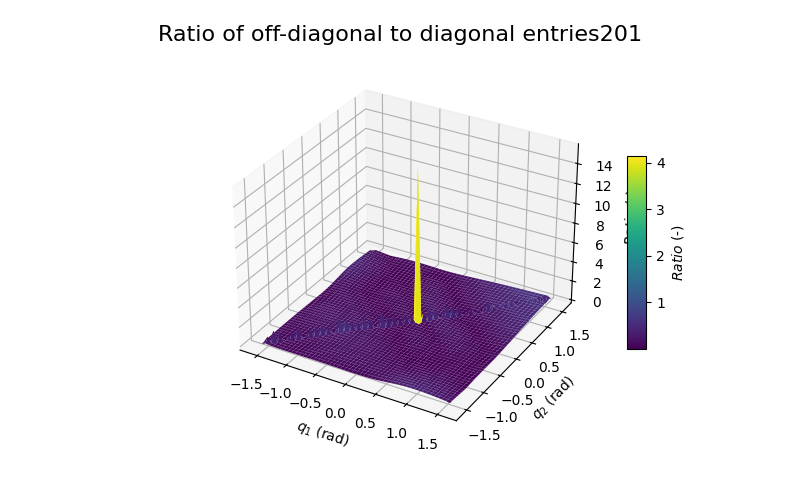

In [12]:

plotters.plot_decoupling(model, device, rp, epoch)

In [81]:
q_test = torch.tensor([[0., 0.]])
theta, J_h, q_hat, J_h_ana = model(q_test)

J_h_inv = torch.linalg.pinv(J_h)
J_h_inv_trans = J_h_inv.transpose(1, 2)




print("J_h:\n", J_h.detach().numpy()[0])
print("J_h_inv:\n", J_h_inv.detach().numpy()[0])
print("J_h_inv_trans:\n", J_h_inv_trans.detach().numpy()[0])



M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q_test[0], q_test[0])
M_q = M_q.unsqueeze(0)
M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h_inv, J_h_inv_trans)
print("M_q:", M_q)
print("M_th:\n", M_th)

print("J_h_inv size:\n", J_h_inv.size())
print("J_h_inv_trans size:\n", J_h_inv_trans.size())
print("M_q size:\n", M_q.size())

off_dia = M_th[:, 1,0]
diag_elements = M_th[:, [0, 1], [0, 1]]
diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
M_th_ratio = off_dia/diag_product
print("M_th_ratio:", M_th_ratio)
print("off_dia:\n", off_dia)
print("diag_product:", diag_product)
print("diag_elements:\n", diag_elements)

print("M_th by hand:\n", J_h_inv_trans @ M_q @ J_h_inv)

print("M_q:\n", M_q)

J_h_ana_inv = torch.linalg.pinv(J_h_ana)
J_h_ana_inv_trans = J_h_ana_inv.transpose(1,2)

print("J_h_ana:\n", J_h_ana.detach().numpy()[0], "\n")
print("J_h_ana_inv:\n", J_h_ana_inv.detach().numpy()[0], "\n")
print("J_h_ana_inv_trans:\n", J_h_ana_inv_trans.detach().numpy()[0], "\n")


M_th_ana, C_th_ana, G_th_ana = dynamics.dynamical_matrices_th(rp, q_test[0], q_test[0]) 
print(M_th_ana.detach().numpy())

J_h:
 [[-1.4142135 -1.4142135]
 [ 0.0034011 -0.0125103]]
J_h_inv:
 [[ -0.55596095  62.84802   ]
 [ -0.1511459  -62.84802   ]]
J_h_inv_trans:
 [[ -0.55596095  -0.1511459 ]
 [ 62.84802    -62.84802   ]]
M_q: tensor([[[12., 12.],
         [12., 12.]]])
M_th:
 tensor([[[6.0000, 0.0000],
         [0.0000, 0.0000]]], grad_fn=<UnsafeViewBackward0>)
J_h_inv size:
 torch.Size([1, 2, 2])
J_h_inv_trans size:
 torch.Size([1, 2, 2])
M_q size:
 torch.Size([1, 2, 2])
M_th_ratio: tensor([0.], grad_fn=<DivBackward0>)
off_dia:
 tensor([0.], grad_fn=<SelectBackward0>)
diag_product: tensor([0.0010], grad_fn=<SqrtBackward0>)
diag_elements:
 tensor([[6.0000, 0.0000]], grad_fn=<IndexBackward0>)
M_th by hand:
 tensor([[[6.0000, 0.0000],
         [0.0000, 0.0000]]], grad_fn=<UnsafeViewBackward0>)
M_q:
 tensor([[[12., 12.],
         [12., 12.]]])
[[-1.4142135 -1.4142135]
 [-1.        -1.       ]] 

[[-0.23570226 -0.16666666]
 [-0.23570226 -0.16666666]] 

[[-0.23570226 -0.23570226]
 [-0.16666666 -0.16666666]] 



In [72]:
a = torch.tensor([[[1, 2], [3, 4]]])
b = a.transpose(1, 2)
c = torch.tensor([[[5, 6], [6, 7]]])
d = b @ c @ a
print(a)
print(b)
print(c)
print(d)

tensor([[[1, 2],
         [3, 4]]])
tensor([[[1, 3],
         [2, 4]]])
tensor([[[5, 6],
         [6, 7]]])
tensor([[[104, 154],
         [154, 228]]])


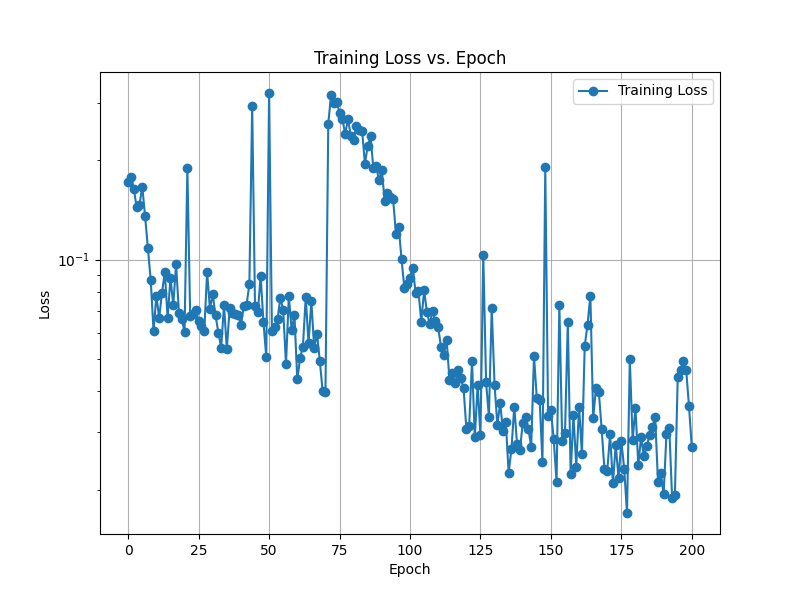

In [13]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='o', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
print(M_th)
print(M_th_ana)

tensor([[ 3.2545e+00, -2.9034e+01],
        [-2.9034e+01,  3.3095e+03]])
tensor([[[  3.0000,   0.0000],
         [  0.0000,   7.9579]],

        [[  3.0000,   0.0000],
         [  0.0000,  94.6046]],

        [[  3.0000,   0.0000],
         [  0.0000, 121.1481]],

        [[  3.0000,   0.0000],
         [  0.0000,  66.6728]],

        [[  3.0000,   0.0000],
         [  0.0000,  20.7679]],

        [[  3.0000,   0.0000],
         [  0.0000,  23.1887]],

        [[  3.0000,   0.0000],
         [  0.0000,   6.0618]],

        [[  3.0000,   0.0000],
         [  0.0000,  12.4544]],

        [[  3.0000,   0.0000],
         [  0.0000, 125.5079]],

        [[  3.0000,   0.0000],
         [  0.0000,  27.4655]],

        [[  3.0000,   0.0000],
         [  0.0000,  88.9502]],

        [[  3.0000,   0.0000],
         [  0.0000,  21.4643]],

        [[  3.0000,   0.0000],
         [  0.0000,  39.4851]],

        [[  3.0000,   0.0000],
         [  0.0000,  21.7927]],

        [[  3.0000,   0.0000],


In [10]:
J_h_inv_trans = torch.tensor([[-1.0020e-01, -4.2116e-01],
                         [ 1.3435e+02, -1.2911e+02]])
M_q = torch.tensor([[12.0000, 11.9141],
                         [11.9141, 12.0000]])
J_h_inv = torch.tensor([[-1.0020e-01,  1.3435e+02],
                         [-4.2116e-01, -1.2911e+02]])

M_th = J_h_inv_trans @ M_q @ J_h_inv

print(M_th)

tensor([[ 3.2545e+00, -2.9034e+01],
        [-2.9034e+01,  3.3095e+03]])


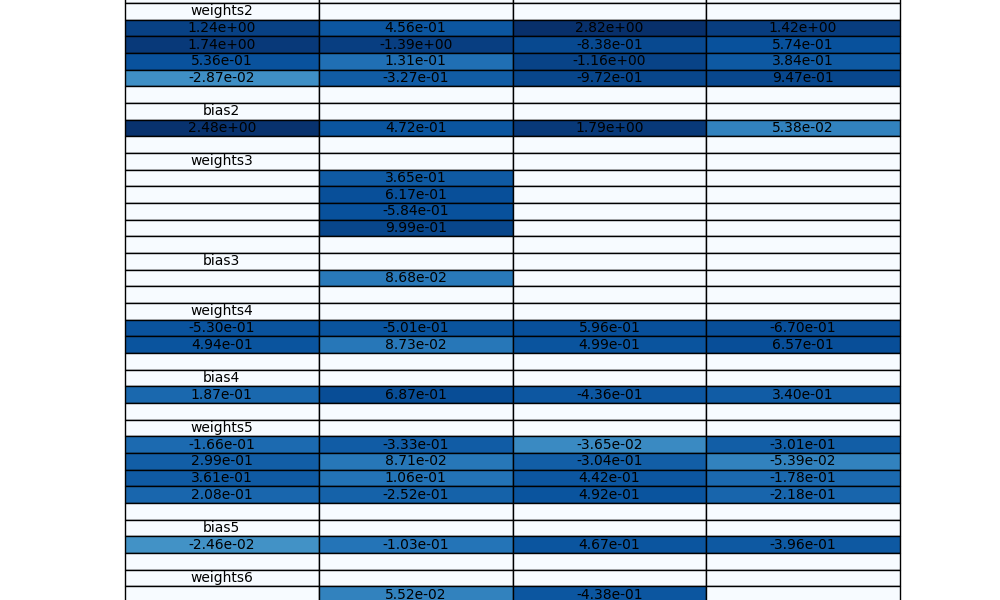

In [11]:
import random
import string

max_neurons = 4
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()